In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 랜덤 시드 설정
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



In [2]:
cd /content/drive/MyDrive

/content/drive/MyDrive


## Custom Dataset

In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None, infer=False):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'binary_masks')
        self.image_filenames = os.listdir(self.image_dir)

        self.infer = infer
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.tif')) #확장자 명만 다름

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #jpg랑 cv2에서 RGB 순서 다름.

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask/255

        #전처리입니다.
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
 os.kill(os.getpid(), 9)

## Define Model

In [4]:
class DoubleConv(nn.Module):
    """반복되는 conv - BN - ReLU 구조 모듈화"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Hyper Parameters

In [5]:
lr= 0.001
epochs = 30
batch_size = 16


## Data Loader

In [6]:
transform = A.Compose( #학습 전 이미지 불러올때 전처리 결정. 일반적인 image 전처리 수행
    [
        A.Resize(384, 384),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = SatelliteDataset(root_dir='./data/train', transform=transform) #train data 폴더 경로 넣기.
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

In [7]:
dataset_size =  len(train_dataset)
# 10%의 Random dataset 데이터셋 생성
subset_size = int(0.1 * dataset_size )
subset_indices = torch.randperm(dataset_size)[:subset_size]
subset_dataset = Subset(train_dataset, subset_indices)
subset_dataloader = DataLoader(subset_dataset, batch_size, shuffle=True, num_workers=2)

In [8]:
test_dataset = SatelliteDataset(root_dir='./data/test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)

dataset_size =  len(test_dataset)
# 10%의 Random dataset 데이터셋 생성
subset_size = int(0.1 * dataset_size)
subset_indices = torch.randperm(dataset_size)[:subset_size]
mini_test = Subset(test_dataset, subset_indices)
mini_test_loader = DataLoader(subset_dataset, batch_size, shuffle=True, num_workers=2)

## Model Train

In [9]:
# model 초기화
model = UNet(3,1).to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

#### 10%로만 할지 말지 ####
train_dataloader = subset_dataloader

train_losses = []
test_losses = []

# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
      images = images.float().to(device)
      masks = masks.float().to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, masks.unsqueeze(1))

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_dataloader))

    test_loss=0
    with torch.no_grad():
      model.eval()
      result = []
      for images, masks in tqdm(mini_test_loader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          test_loss += loss.item()
    test_losses.append(test_loss/len(mini_test_loader))


    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}, Test Loss : {test_loss/len(mini_test_loader)}')



100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Epoch 1, Loss: 0.46188579003016156, Test Loss : 5.156516536076864


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 2, Loss: 0.33241246740023295, Test Loss : 0.398057480653127


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Epoch 3, Loss: 0.30428282817204794, Test Loss : 0.3069778094689051


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 4, Loss: 0.2727236658334732, Test Loss : 0.25176528592904407


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 5, Loss: 0.2509206920862198, Test Loss : 0.2475208729505539


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 6, Loss: 0.24273494780063629, Test Loss : 0.22241864899794261


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


Epoch 7, Loss: 0.24591186344623567, Test Loss : 0.21279257237911225


100%|██████████| 15/15 [00:06<00:00,  2.50it/s]


Epoch 8, Loss: 0.23531528413295746, Test Loss : 0.21577560702959697


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Epoch 9, Loss: 0.2245819240808487, Test Loss : 0.20504034111897151


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 10, Loss: 0.21050252318382262, Test Loss : 0.22801605065663655


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 11, Loss: 0.21044113139311474, Test Loss : 0.22284333705902098


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 12, Loss: 0.21458154320716857, Test Loss : 0.1999855101108551


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Epoch 13, Loss: 0.20949608584245047, Test Loss : 0.20101299186547597


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 14, Loss: 0.21623830596605936, Test Loss : 0.19972142875194548


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


Epoch 15, Loss: 0.19683153331279754, Test Loss : 0.188823202252388


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 16, Loss: 0.1872584581375122, Test Loss : 0.18358965317408243


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 17, Loss: 0.19288415710131326, Test Loss : 0.1901838819185893


100%|██████████| 15/15 [00:05<00:00,  2.50it/s]


Epoch 18, Loss: 0.19149270057678222, Test Loss : 0.24756284256776173


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Epoch 19, Loss: 0.2056098481019338, Test Loss : 0.2316318263610204


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Epoch 20, Loss: 0.19431958297888438, Test Loss : 0.188544366757075


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 21, Loss: 0.18283654948075612, Test Loss : 0.16831047336260477


100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


Epoch 22, Loss: 0.17729584674040477, Test Loss : 0.1679237241546313


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 23, Loss: 0.1681395063797633, Test Loss : 0.15549357781807582


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 24, Loss: 0.17045393685499827, Test Loss : 0.15998224765062333


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


Epoch 25, Loss: 0.1707105189561844, Test Loss : 0.18603646953900654


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Epoch 26, Loss: 0.1794796347618103, Test Loss : 0.1729411631822586


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


Epoch 27, Loss: 0.16919719974199932, Test Loss : 0.18492839336395264


100%|██████████| 15/15 [00:05<00:00,  2.53it/s]


Epoch 28, Loss: 0.17382305413484572, Test Loss : 0.15439889480670294


100%|██████████| 15/15 [00:05<00:00,  2.55it/s]


Epoch 29, Loss: 0.16236067414283753, Test Loss : 0.15044371038675308


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]

Epoch 30, Loss: 0.15814779400825502, Test Loss : 0.1485224947333336


In [10]:
torch.save(model.state_dict(), './model.pt')

## Epoch에 따른 Loss 변화

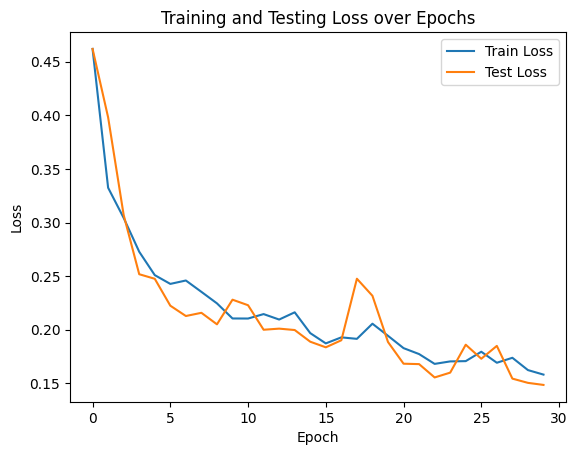

In [19]:
test_losses[0]= train_losses[0] #첫 test loss 너무커서
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 잘 되는지 결과 이미지 출력해보기

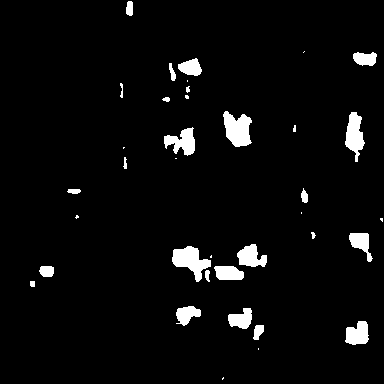

In [26]:
with torch.no_grad():
    model.eval()
    img = train_dataset[0][0].unsqueeze(0).float().to(device)

    output = model(img)
    output = torch.sigmoid(output).squeeze(0).permute(1,2,0).cpu().numpy() #output에 sigmoid => 건물일 확률 + shape 이미지 RGB 모양으로
    output = (output > 0.5).astype(np.uint8) # Threshold = 0.5 이상이면 건물이라 판단
    output = output*255 # 1이면 하얗게 출력하기 위해 255 곱하기

    cv2_imshow(output)


## Inference 및 최종 성능 평가

In [28]:
all_true_masks = []
all_predicted_masks = []
with torch.no_grad():
    model.eval()
    result = []
    for images, masks in tqdm(mini_test_loader):
        images = images.float().to(device)
        true_masks = masks.float().to(device)

        outputs = model(images)

        # CPU로 이동
        true_masks = true_masks.squeeze().cpu().numpy()
        outputs = outputs.squeeze().cpu().numpy()
        outputs = (outputs > 0.5).astype(np.uint8)


        # 리스트에 추가
        all_true_masks.extend(true_masks)
        all_predicted_masks.extend(outputs)

# 실제 마스크와 예측 마스크 비교
true_masks_flat = np.concatenate(all_true_masks).ravel()
predicted_masks_flat = np.concatenate(all_predicted_masks).ravel()

# Precision, Recall, IoU, Dice 계산
precision = precision_score(true_masks_flat, predicted_masks_flat)
recall = recall_score(true_masks_flat, predicted_masks_flat)
iou = jaccard_score(true_masks_flat, predicted_masks_flat)
dice_coefficient = f1_score(true_masks_flat, predicted_masks_flat)

# 결과 출력
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'IoU: {iou}')
print(f'Dice Coefficient: {dice_coefficient}')



100%|██████████| 15/15 [00:05<00:00,  2.57it/s]


Precision: 0.8620404554338721
Recall: 0.6727061512277358
IoU: 0.6073225400921565
Dice Coefficient: 0.755694672280693
